# Modular variables

In [1]:
from IPython import get_ipython

if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import collections

import latenta as la

la.logger.setLevel("INFO")

## Simple example

In [2]:
n_cells = 50
cell_ids = [str(i) for i in range(n_cells)]
cells = la.Dim(pd.Series(cell_ids, name="cell"))

x = la.Fixed(pd.Series(np.random.uniform(0, 3, n_cells), index=cells.index), label="x")

In [3]:
n_genes = 100
genes = la.Dim(pd.Series([str(i) for i in range(n_genes)]), id="gene")


def random_coefficient(n_genes):
    return (
        np.random.choice([-1, 1], n_genes)
        * np.random.normal(3.0, 1.0, n_genes)
        * (np.random.random(n_genes) > 0.5)
    )


slope = la.Fixed(
    pd.Series(random_coefficient(n_genes), index=genes.index), label="slope"
)
intercept = la.Fixed(
    pd.Series(random_coefficient(n_genes), index=genes.index), label="intercept"
)
final = la.Fixed(
    pd.Series(random_coefficient(n_genes), index=genes.index), label="final"
)

slope_subset = la.Fixed(
    pd.Series(random_coefficient(10), index=genes.index[:10]), label="slope_subset"
)

In [6]:
y_linear = la.links.scalar.Linear(x=x, a=slope)
y = la.modular.Additive(
    linear=y_linear, definition=y_linear.value_definition, subsettable={genes}
)

We can add extra terms:

In [7]:
y_sigmoid = la.links.scalar.Sigmoid(x=x, a=final)
y.sigmoid = y_sigmoid

y_exponential = la.links.scalar.Exp(x=x, a=final)
y.exponential = y_exponential

The terms can have a subset of the modular variable's dimensions:

In [8]:
y.simply_x = x
y.simply_slope = slope

In fact, a terms dimension can be a subset, as long as this dimension was registered as "subsettable" when defining the modular variable:

In [9]:
y_linear_subset = la.links.scalar.Linear(x=x, a=slope_subset)
y.linear_subset = y_linear_subset
y_linear.prior_xr().shape, y_linear_subset.prior_xr().shape

((50, 100), (50, 10))

We can also remove terms

In [10]:
del y.exponential

In [11]:
scale = la.Fixed(
    pd.Series(np.random.uniform(1.0, 1.2, n_genes), index=genes.index), label="scale"
)
dist = la.distributions.Normal(loc=y, scale=scale)


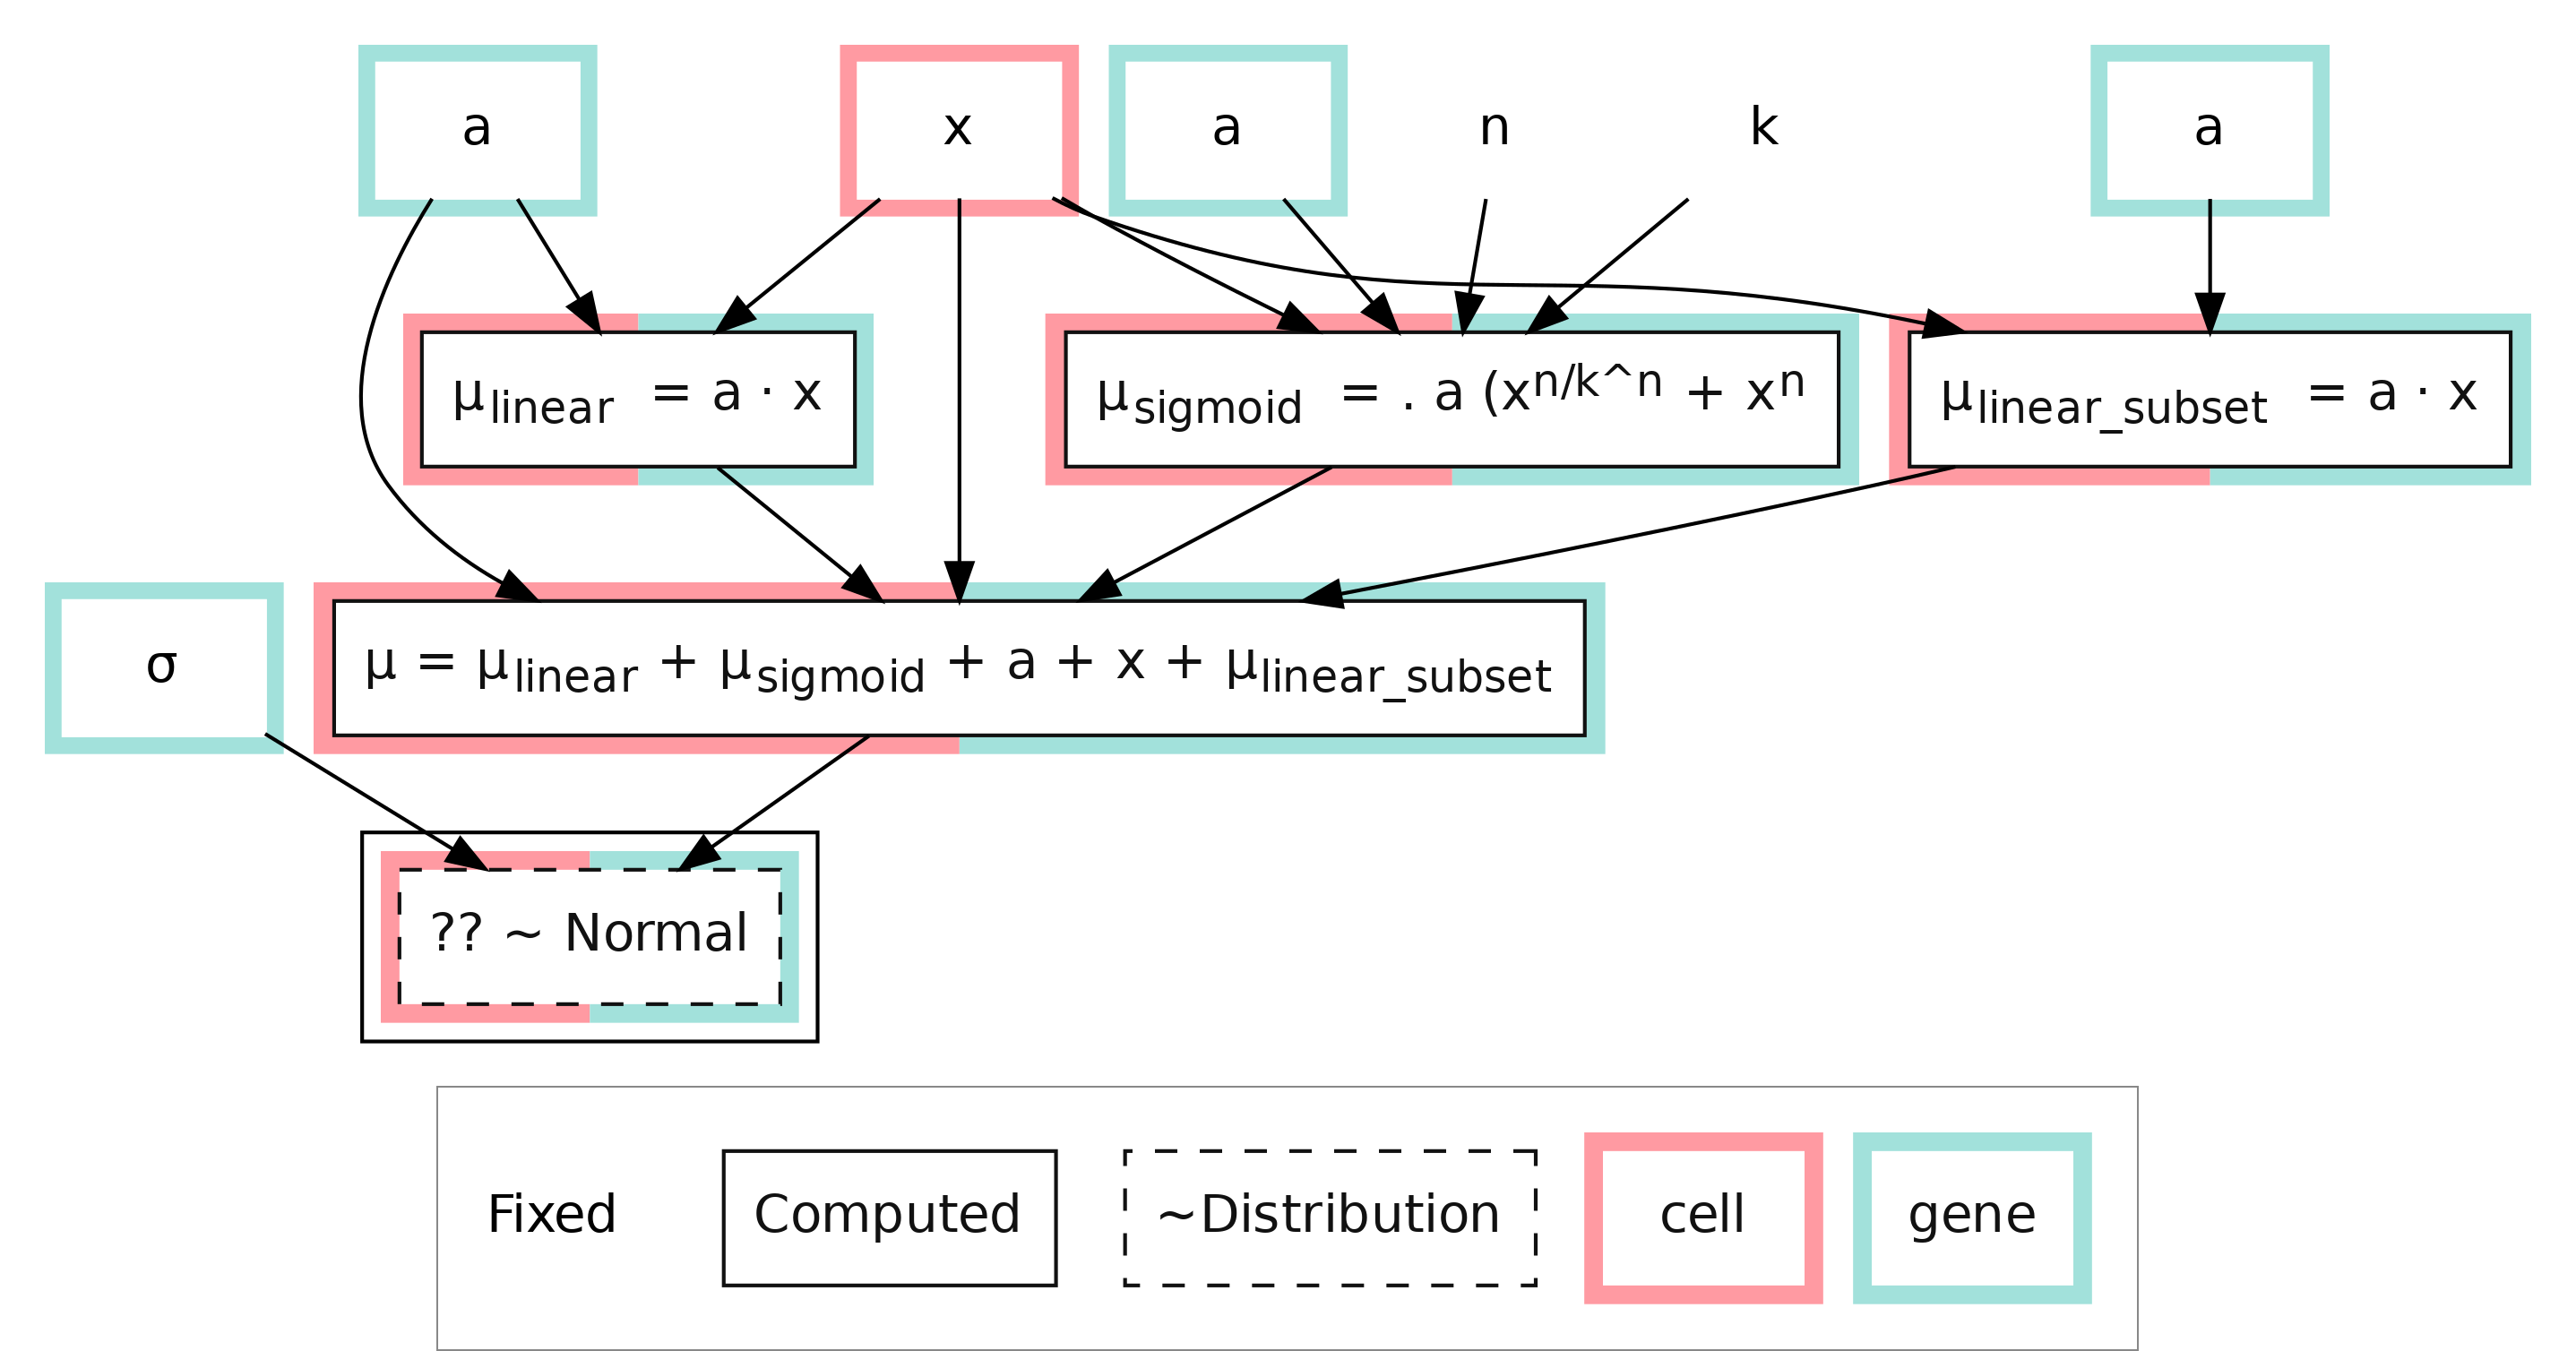

In [12]:
model_gs = la.Root(dist, label="ground truth", symbol="gs")
model_gs.plot()

In [13]:
posterior = la.posterior.Posterior(dist)
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

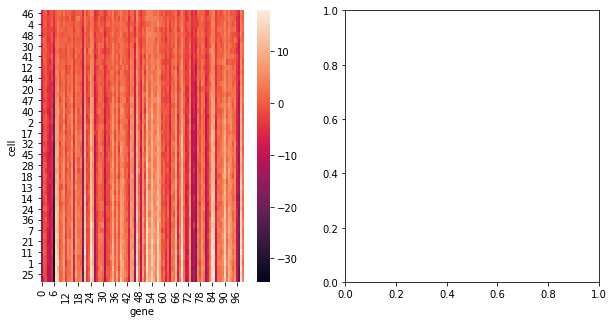

In [14]:
observation_value = posterior.samples[dist].sel(sample=0).to_pandas()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
cell_order = model_gs.find("x").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax=ax0)

## Types of modular variables

In [18]:
y = la.modular.Multiplicative(
    linear=y_linear,
    linear_subset=y_linear_subset,
    definition=y_linear.value_definition,
    subsettable={genes},
)

In [19]:
y.prior_pd()

gene,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,,,,,,,,,,,,,,,,,,,,,
0,65.045753,0.0,-0.0,-0.0,-0.0,-0.0,190.214493,0.0,0.0,0.0,...,8.064908,0.0,7.111903,0.0,0.0,0.0,-9.277843,-17.152800,10.168778,0.0
1,63.752354,0.0,-0.0,-0.0,-0.0,-0.0,186.432190,0.0,0.0,0.0,...,7.984322,0.0,7.040840,0.0,0.0,0.0,-9.185137,-16.981407,10.067170,0.0
2,13.350176,0.0,-0.0,-0.0,-0.0,-0.0,39.040165,0.0,0.0,0.0,...,3.653705,0.0,3.221958,0.0,0.0,0.0,-4.203209,-7.770860,4.606837,0.0
3,1.314643,0.0,-0.0,-0.0,-0.0,-0.0,3.844434,0.0,0.0,0.0,...,1.146552,0.0,1.011068,0.0,0.0,0.0,-1.318990,-2.438537,1.445650,0.0
4,0.055023,0.0,-0.0,-0.0,-0.0,-0.0,0.160906,0.0,0.0,0.0,...,0.234565,0.0,0.206847,0.0,0.0,0.0,-0.269843,-0.498884,0.295756,0.0
5,0.296747,0.0,-0.0,-0.0,-0.0,-0.0,0.867782,0.0,0.0,0.0,...,0.544732,0.0,0.480363,0.0,0.0,0.0,-0.626658,-1.158560,0.686835,0.0
6,12.469594,0.0,-0.0,-0.0,-0.0,-0.0,36.465061,0.0,0.0,0.0,...,3.531149,0.0,3.113884,0.0,0.0,0.0,-4.062222,-7.510203,4.452311,0.0
7,47.954979,0.0,-0.0,-0.0,-0.0,-0.0,140.235641,0.0,0.0,0.0,...,6.924793,0.0,6.106512,0.0,0.0,0.0,-7.966259,-14.727954,8.731245,0.0
8,0.094638,0.0,-0.0,-0.0,-0.0,-0.0,0.276751,0.0,0.0,0.0,...,0.307626,0.0,0.271274,0.0,0.0,0.0,-0.353891,-0.654272,0.387875,0.0
